# Unsupervised Learning and Anomaly Detection

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd
import os.path
import subprocess
import matplotlib.collections
import scipy.signal
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')

import torch
import copy
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
from scipy.io import arff

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#### <span style="color:LightPink">Helpers for Getting, Loading, and Locating Data</span>

In [53]:
def wget_data(url: str, local_path='./tmp_data'):
  os.makedirs(local_path, exist_ok=True)

  p = subprocess.Popen(["wget", "-nc", "-P", local_path, url], stderr=subprocess.PIPE, encoding='UTF-8')
  rc = None

  while rc is None:
    line = p.stderr.readline().strip('\n')
    if len(line) > 0:
      print(line)
    rc = p.poll()

def locate_data(name, check_exists=True):
    local_path='./tmp_data'
    path = os.path.join(local_path, name)
    if check_exists and not os.path.exists(path):
        raise RuxntimeError('No such data file: {}'.format(path))
    return path

## <span style="color:Orange">Get Data</span>

In [ ]:
wget_data('https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/data/ECG5000_TRAIN.arff')
wget_data('https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/data/ECG5000_TEST.arff')

File ‘./tmp_data/ECG5000_TRAIN.arff’ already there; not retrieving.
File ‘./tmp_data/ECG5000_TEST.arff’ already there; not retrieving.


## <span style="color:Orange">Networks for Unsupervised Learning</span>

Neural networks are usually used for supervised learning since their learning is accomplished by optimizing a loss function that compares the network's outputs with some target values. However, it is possible to perform unsupervised learning if we can somehow use the same data for both the input values and the target output values. This requires that the network have the same number of input and output nodes, and effectively means that we are asking it to learn the identify function, which does not sound obviously useful.

Suppose we have a single hidden layer with the same number of nodes as the input and output layers, then all the network has to do is pass each input value through to the output, which does not require any training at all!  However, if the hidden layer has fewer nodes then we are asking the network to solve a more interesting problem: how can the input dataset be encoded and then decoded. This is the same <span style="color:Violet">dimensionality reduction</span> problem we discussed [earlier](https://illinois-mlp.github.io/MachineLearningForPhysics/_sources/lectures/Dimensionality.html), and is known as an <span style="color:Violet">autoencoder network</span> as we covered in the [AutoEncoders notebook](https://illinois-mlp.github.io/MachineLearningForPhysics/_sources/lectures/AutoEncoders.html) since it learns to encode itself:

<div>
<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/AutoEncoders-autoencoder-visual.png" width=1000></img>
</div>

The network can be thought of as the combination of separate encoder and decoder networks, with the encoder feeding its output latent variables $\mathbf{z}$ into the decoder. Although the architecture looks symmetric, the encoder and decoder will generally learn different parameters because of the asymmetry introduced by nonlinear activations. The figure represents a high-level design pattern and the internal architectures of the encoder and decoder networks should be customized for the type of data being encoded (and typically combined convolutional and dense layers).

## <span style="color:Orange">Example: Time Series Anomaly Detection using LSTM Autoencoders</span>

In this example, we will learn to:
* Prepare a dataset for Anomaly Detection from Time Series Data
* Build an LSTM Autoencoder with PyTorch
* Train and evaluate your model
* Choose a threshold for anomaly detection
* Classify unseen examples as normal or anomaly

While our Time Series data is univariate (we have only 1 feature), the code should work for multivariate datasets (multiple features) with little or no modification. Feel free to try it!

### <span style="color:LightGreen">Brief LSTM Review</span>

A <span style="color:Violet">Long Short-Term Memory</span> (LSTM) is a type of Recurrent Neural Network (RNN) designed to handle long-term dependencies in sequential data, such as text, time series, and speech. LSTMs are known for their ability to mitigate the vanishing gradient problem that plagues standard RNNs, allowing them to learn and remember information over longer sequences of data.

Key Features of LSTMs:

* ___<span style="color:Violet">Memory Cell</span>___: LSTMs introduce a memory cell that acts as a "memory" for the network, allowing it to store and retrieve information over time.

*  ___<span style="color:Violet">Gates</span>___: LSTMs use "gates" (input, forget, and output gates) to control the flow of information into, out of, and within the memory cell.

* ___<span style="color:Violet">Vanishing Gradient Problem</span>___: LSTMs are designed to prevent the gradients from vanishing or exploding as they propagate through the network over time, making them more effective for learning long-term relationships in sequential data.

* ___<span style="color:Violet">Sequence Learning</span>___: LSTMs are particularly well-suited for tasks that involve processing sequential data, such as natural language processing (language modeling, machine translation), speech recognition, and time series forecasting.

How LSTMs Work:

1. ___<span style="color:Violet">Input</span>___: The LSTM receives an input sequence, where each input represents a time step. 

2. ___<span style="color:Violet">Gates</span>___: The gates regulate the flow of information into the memory cell and the output from the cell. 

3. ___<span style="color:Violet">Memory Cell</span>___: The memory cell stores and updates its internal state based on the input and the previous state. 

4. ___<span style="color:Violet">Output</span>___: The LSTM produces an output at each time step based on the current cell state and the input.

Advantages of LSTMs:

* ___<span style="color:Violet">Long-term dependencies</span>___: LSTMs are capable of learning long-term dependencies in sequential data.

* ___<span style="color:Violet">Vanishing gradient problem</span>___: LSTMs mitigate the vanishing gradient problem, making them more effective for processing long sequences.

* ___<span style="color:Violet">Wide range of applications</span>___: LSTMs have been successfully applied to many sequence learning tasks.

### <span style="color:LightGreen">Data</span>

The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. It measures the electrical activity of your heart. It uses small electrodes attached to your skin to detect the tiny electrical signals that control your heartbeat. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

* ___<span style="color:Violet">What it measures</span>___: An ECG records the electrical impulses that cause your heart to beat, showing how the signals travel through your heart's chambers.

* ___<span style="color:Violet">How it's done</span>___: During an ECG, electrodes are attached to your chest, arms, and legs using adhesive patches or small suction cups.

* ___<span style="color:Violet">What it shows</span>___: The ECG produces a graphical representation of your heart's electrical activity, known as an ECG tracing.

* ___<span style="color:Violet">Why it's used</span>___: ECGs are used to diagnose and monitor various heart conditions, including arrhythmias, coronary artery disease, heart attacks, and heart failure.

* ___<span style="color:Violet">What it can reveal</span>___: An ECG can help doctors detect changes in heart rate, rhythm, and electrical conduction, which may indicate a heart problem.

We have 5 types of hearbeats (classes):

- Normal (N)
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB)
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle.
Frequency: 60–100 per minute (Humans)
Duration: 0.6–1 second (Humans) [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


The data comes in multiple formats. We'll load the `arff` files into Pandas data frames:

In [56]:
with open(locate_data('ECG5000_TRAIN.arff')) as f:
  data, meta = arff.loadarff(f)
  train = pd.DataFrame(data)
  print(train.shape)

with open(locate_data('ECG5000_TEST.arff')) as f:
  data, meta = arff.loadarff(f)
  test = pd.DataFrame(data)
  print(test.shape)

(500, 141)
(4500, 141)


We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it:

In [57]:
df = pd.concat([train, test])
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [58]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,b'1'
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,b'1'
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,b'1'
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,b'1'
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,b'1'


We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:

In [ ]:
CLASS_NORMAL = 1
#class_names = ['Normal','R on T','PVC','SP','UB'] # This ordering sometimes produces wrong counts histogram. Need to check if it affects plots that use class_names
class_names = ['Normal','PVC','R on T','SP','UB']

Next, we'll rename the last column to `target`, so its easier to reference it:

In [79]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

### <span style="color:LightGreen">Exploratory Data Analysis</span>

Let's check how many examples for each heartbeat class do we have:

In [80]:
df.target.value_counts()

target
b'1'    2919
b'2'    1767
b'4'     194
b'3'      96
b'5'      24
Name: count, dtype: int64

Let's plot the results:

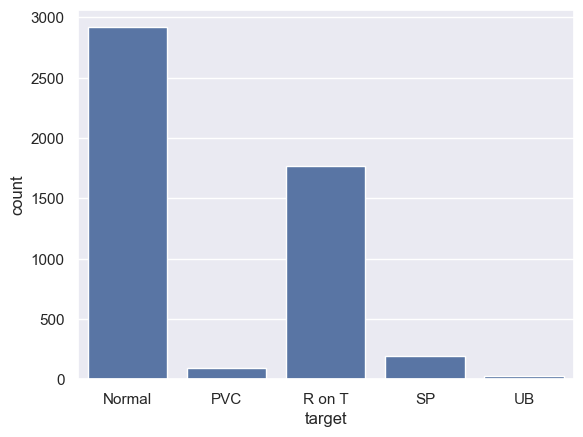

In [83]:
ax = sns.countplot(x=df.target, data=df)
ax.set_xticklabels(class_names)
plt.show()

The normal class, has by far, the most examples. This is great because we'll use it to train our model.

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [12]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

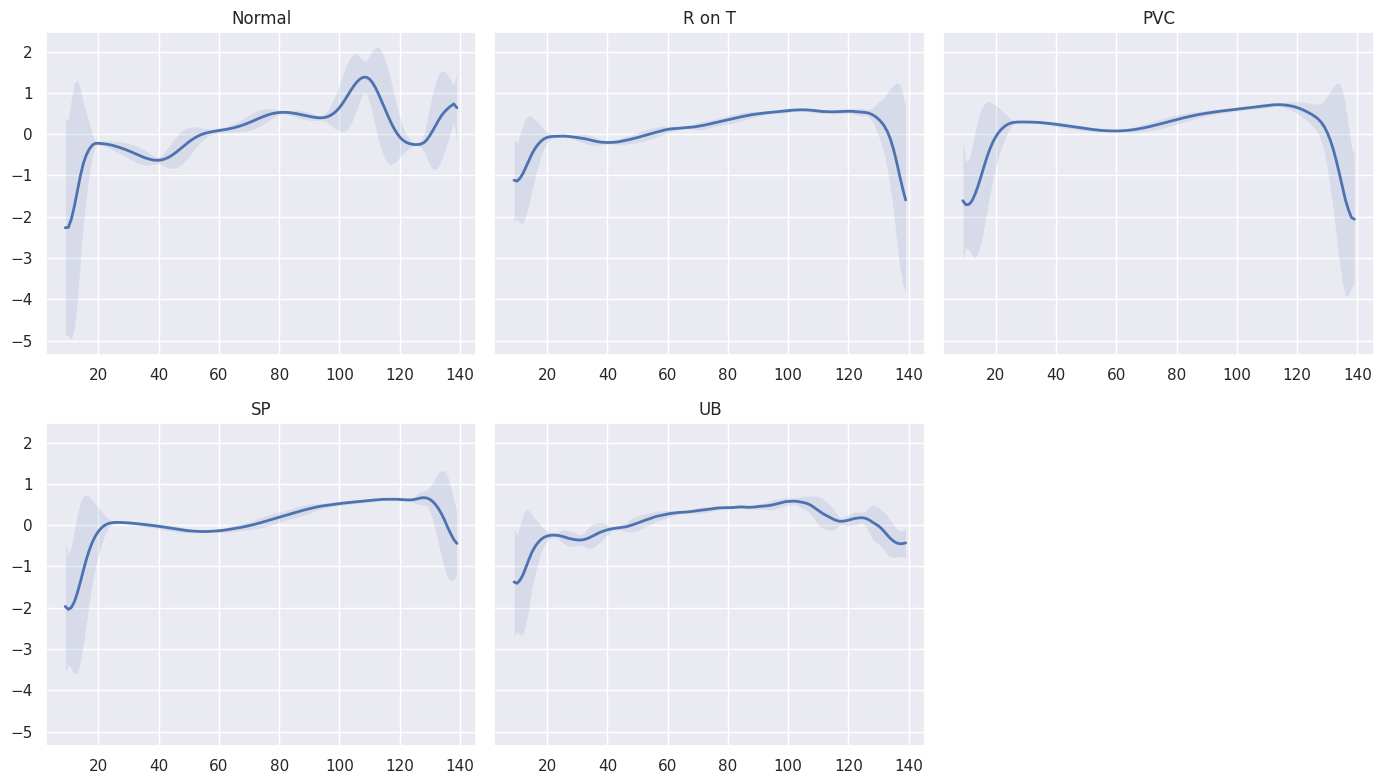

In [13]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

It is very good that the normal class has a distinctly different pattern than all other classes. Maybe our model will be able to detect anomalies?

### <span style="color:LightGreen">LSTM Autoencoder</span>

The [Autoencoder's](https://en.wikipedia.org/wiki/Autoencoder) job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.

#### <span style="color:LightPink">Reconstruction Loss</span>

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as *reconstruction loss*. Cross-entropy loss and Mean squared error are common examples.

### <span style="color:LightGreen">Anomaly Detection in ECG Data</span>

We'll use normal heartbeats as training data for our model and record the *reconstruction loss*. But first, we need to prepare the data:

#### <span style="color:LightPink">Data Preprocessing</span>

Let's get all normal heartbeats and drop the target (class) column:

In [14]:
normal_df = df[df.target == str(CLASS_NORMAL).encode('utf-8')].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

We'll merge all other classes and mark them as anomalies:

In [15]:
anomaly_df = df[df.target != str(CLASS_NORMAL).encode('utf-8')].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

We'll split the normal examples into train, validation and test sets:

In [16]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [17]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

Let's create some datasets:

In [18]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

#### <span style="color:LightPink">LSTM Autoencoder</span>

<div>
<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/UnsupervisedLearningAnomalyDetection-autoencoder_architecture.png" width=1000></img>
</div>

*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

We'll use the LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the *Encoder*:

In [19]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

The *Encoder* uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a *Decoder*:

In [20]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [21]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [22]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

#### <span style="color:LightPink">Training</span>

Let's write a helper function for our training process:

In [23]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:

In [24]:
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=150
)

Epoch 1: train loss 70.19056519843167 val loss 55.545283333840224
Epoch 2: train loss 57.20439573393287 val loss 53.2183632053206
Epoch 3: train loss 53.80251925667175 val loss 51.787326721608025
Epoch 4: train loss 53.50249311915332 val loss 52.1923034850241
Epoch 5: train loss 51.639859836459976 val loss 50.23866700312384
Epoch 6: train loss 47.88762839923506 val loss 53.42915126813556
Epoch 7: train loss 44.5796035203853 val loss 42.75591913425068
Epoch 8: train loss 43.05668973250045 val loss 41.69073425136735
Epoch 9: train loss 36.804902854344384 val loss 28.941658182762588
Epoch 10: train loss 29.600385176948077 val loss 27.772434221599696
Epoch 11: train loss 29.258839591478733 val loss 33.79314185002558
Epoch 12: train loss 27.309336170271873 val loss 29.403204198583403
Epoch 13: train loss 26.56631477529702 val loss 25.562526377394743
Epoch 14: train loss 25.581571012771402 val loss 26.178377704815652
Epoch 15: train loss 24.73337686278079 val loss 28.74295396772261
Epoch 16:

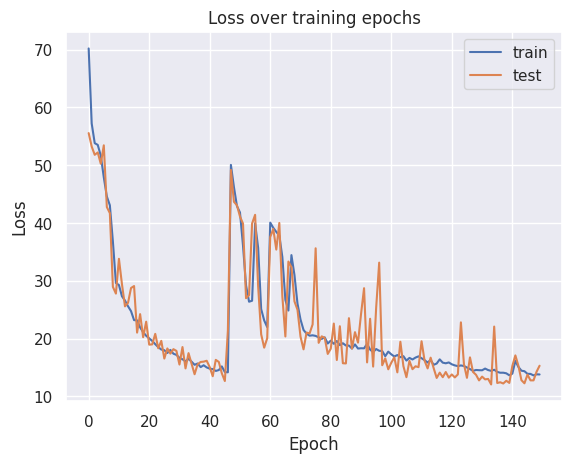

In [25]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. Seems like we might've needed a larger validation set to smoothen the results, but that'll do for now.

#### <span style="color:LightPink">Saving the Model</span>

Let's store the model for later use:

In [26]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

Uncomment the next lines, if you want to download and load the pre-trained model:

In [27]:
# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
# model = torch.load('model.pth')
# model = model.to(device)

#### <span style="color:LightPink">Choosing a Threshold</span>

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [28]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

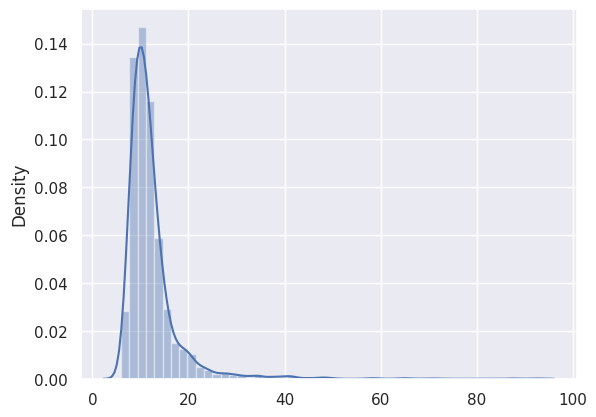

In [29]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [30]:
THRESHOLD = 26

#### <span style="color:LightPink">Evaluation</span>

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

#### <span style="color:LightPink">Normal Heartbeats</span>

Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

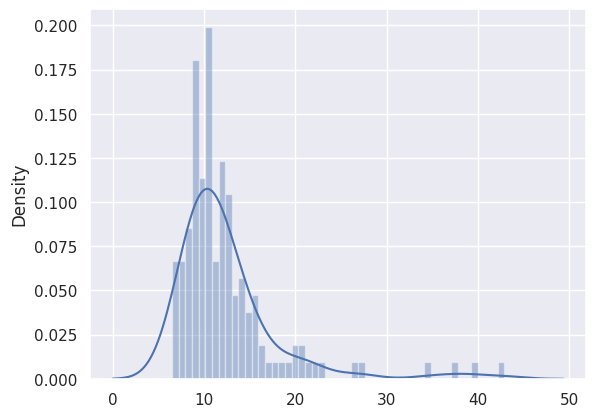

In [31]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

We'll count the correct predictions:

In [32]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 139/145


#### <span style="color:LightPink">Anomalies</span>

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:

In [33]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies:

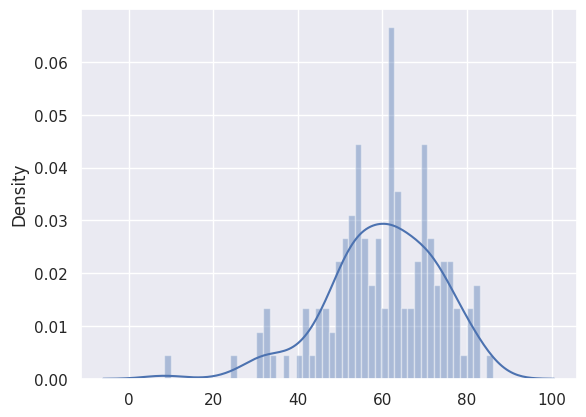

In [34]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

In [35]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 143/145


We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

#### <span style="color:LightPink">Looking at Examples</span>

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [36]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

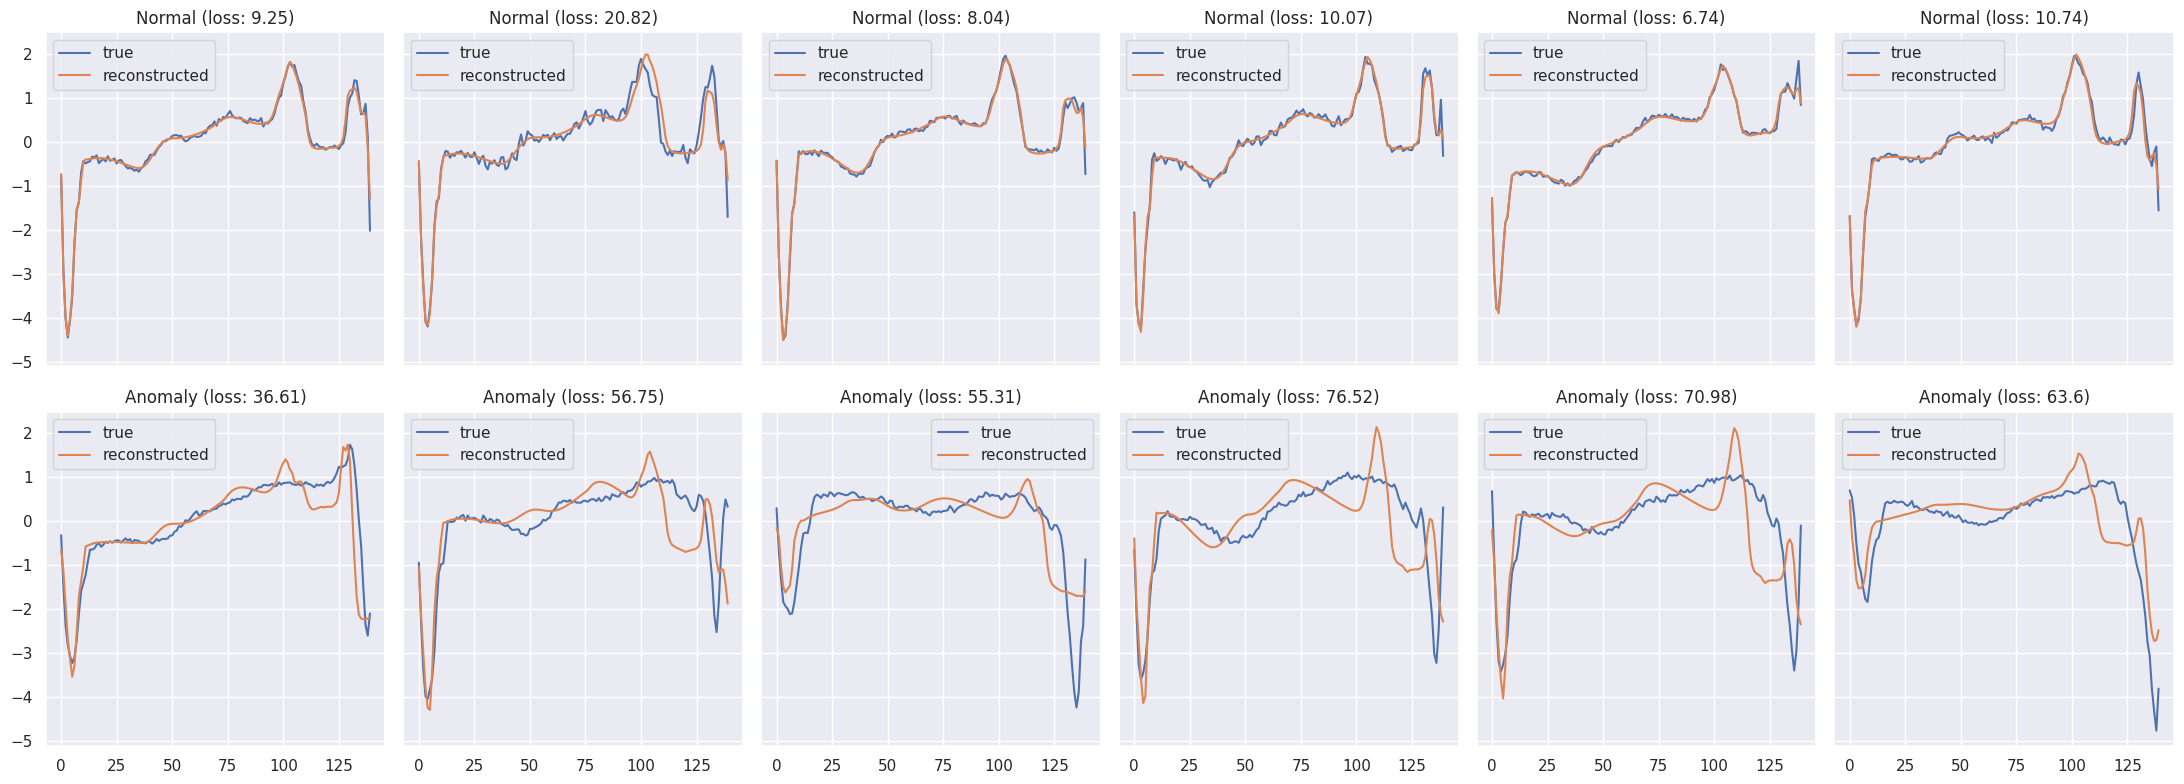

In [37]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout()

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer
* Modified from this [notebook](https://colab.research.google.com/github/curiousily/Getting-Things-Done-with-Pytorch/blob/master/06.time-series-anomaly-detection-ecg.ipynb) 

© Copyright 2025